# IMPORTS

In [24]:
import gdown
import zipfile
import os
from tqdm import tqdm
import shutil

import torchaudio
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB

import pandas as pd
import matplotlib.pyplot as plt

# Data manipulation

Now we are gonna download and manipulate the data to make them usable for the dataset that we are gonna create

In [ ]:
# === CONFIGURAZIONE ===
FILE_ID = "1zHPs5LurXfPwDDD2jXhpegEchvXTQWRP"  # <-- Cambia qui se serve
OUTPUT_ZIP = "train.zip"
EXTRACT_DIR = "train_data"

# === 1. Scarica da Google Drive con barra di progresso ===
print("Inizio download del file da Google Drive...")

# Usa gdown per scaricare con URL
url = f"https://drive.google.com/uc?id={FILE_ID}"

# Usa una funzione di hook per mostrare la barra
def tqdm_hook(t):
    last_b = [0]

    def update_to(b=1, bsize=1, tsize=None):
        if tsize is not None:
            t.total = tsize
        t.update((b - last_b[0]) * bsize)
        last_b[0] = b
    return update_to

with tqdm(unit='B', unit_scale=True, desc=OUTPUT_ZIP, miniters=1) as t:
    gdown.download(url, OUTPUT_ZIP, quiet=True, use_cookies=False)

print("Download completato!")

# === 2. Estrazione del file ZIP ===
print(f"Estrazione di {OUTPUT_ZIP} nella cartella '{EXTRACT_DIR}'...")

# Crea cartella se non esiste
if not os.path.exists(EXTRACT_DIR):
    os.makedirs(EXTRACT_DIR)

with zipfile.ZipFile(OUTPUT_ZIP, 'r') as zip_ref:
    # tqdm per mostrare il progresso dei file estratti
    for file in tqdm(zip_ref.namelist(), desc="Estrazione file"):
        zip_ref.extract(file, EXTRACT_DIR)

print("Estrazione completata!")

os.remove(OUTPUT_ZIP)  # Rimuovi il file ZIP dopo l'estrazione


Inizio download del file da Google Drive...


train.zip: 0.00B [37:45, ?B/s]


Download completato!
Estrazione di train.zip nella cartella 'train_data'...


Estrazione file: 100%|██████████| 31994/31994 [02:07<00:00, 251.88it/s]

Estrazione completata!


Now we'll create a Dataframe with the following structure:
audio_PATH, score, audio_PATH

Our "degradation_points.txt" has the points decided on the type of noise that has been applied on the original audio (0: small noise, 1.0: big noise).

Our goal is to create a model that assign a quality score to input audio (0: bad_quality, 1: very good quality). So to understand the idea behind the assigned score we have to consider 2 different cases:
- (clean, degraded): the final score will be 1.0 - score, cause if we had applied big noise the initial score will be almost 1, so the final quality score will be near 0.
- (degraded, clean): the final quality score will be equal to 1.0 cause clean represent the optimal quality that has to be reached

In [ ]:
# Prepare a csv file containing all the necessary information
clean_dir = os.path.join(EXTRACT_DIR, 'train', 'clean')
degraded_dir = os.path.join(EXTRACT_DIR, 'train', 'degraded')
score_file = os.path.join(EXTRACT_DIR, 'degradation_points.txt')

# Load score file
df = pd.read_csv(score_file, sep='\t', header=None, names=['filename', 'score'])
# Add clean_path on csv
df['clean_path'] = df['filename'].apply(lambda x: os.path.join(clean_dir, x.split('/')[-1].split('_')[0] + '.mp3'))
df['score'] = df['score'].astype(float)
df['degraded_path'] = df['filename'].apply(lambda x: os.path.join(degraded_dir, x.split('/')[-1]))

df = df[["clean_path", "score", "degraded_path"]]

# Coppie (clean → degraded): il degraded è il target, qualità = 1 - score
forward = pd.DataFrame({
    "source_path": df["clean_path"],
    "target_path": df["degraded_path"],
    "quality_score": 1.0 - df["score"]
})

# Coppie (degraded → clean): il clean è il target, qualità massima = 1.0
backward = pd.DataFrame({
    "source_path": df["degraded_path"],
    "target_path": df["clean_path"],
    "quality_score": 1.0
})

# Combina
paired_df = pd.concat([forward, backward], ignore_index=True)

# Visualizza esempio
# print(paired_df.head())

# Salva se vuoi
paired_df.to_csv("train_data/paired_audio_quality_dataset.csv", index=False, header=False)



# Dataset build

In [27]:
class AudioPairQualityDataset(Dataset):
    def __init__(self, csv_path, transform=None, target_sample_rate=16000, duration=3.0):
        self.data = pd.read_csv(csv_path, header=None, names=["source_path", "target_path", "quality_score"])
        self.transform = transform
        self.sample_rate = target_sample_rate
        self.num_samples = int(self.sample_rate * duration)

    def __len__(self):
        return len(self.data)

    def _load_audio(self, path):
        waveform, sr = torchaudio.load(path)
        # Resample if needed
        if sr != self.sample_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)
            waveform = resampler(waveform)
        # Mono
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)
        # Pad/Trim to fixed length
        if waveform.shape[1] < self.num_samples:
            padding = self.num_samples - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, padding))
        else:
            waveform = waveform[:, :self.num_samples]
        return waveform

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        source_audio = self._load_audio(row["source_path"])
        target_audio = self._load_audio(row["target_path"])
        score = torch.tensor(row["quality_score"], dtype=torch.float32)

        if self.transform:
            source_audio = self.transform(source_audio)
            target_audio = self.transform(target_audio)

        return {
            'source_audio': source_audio,
            'target_audio': target_audio,
            'score': score
        }

In [28]:
csv_path = os.path.join(EXTRACT_DIR, 'paired_audio_quality_dataset.csv')

# Full dataset
full_dataset = AudioPairQualityDataset(csv_path)

# Define lengths for the splits
total_len = len(full_dataset)
train_len = int(0.7 * total_len)
val_len = int(0.15 * total_len)
test_len = total_len - train_len - val_len  # Assicura somma esatta

# Random splits for train, test and validation
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_len, val_len, test_len],
    generator=torch.Generator().manual_seed(42)  # seed riproducibile
)

# DataLoader per ciascun set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [29]:
# get one dataloader element
print("Train loader example:")
for batch in train_loader:
    spectrogram = batch['source_audio']
    score = batch['score']
    print(f"Spectrogram shape: {spectrogram.shape}, Score shape: {score.shape}")
    break

Train loader example:
Spectrogram shape: torch.Size([32, 1, 48000]), Score shape: torch.Size([32])


TypeError: Invalid shape (48000,) for image data

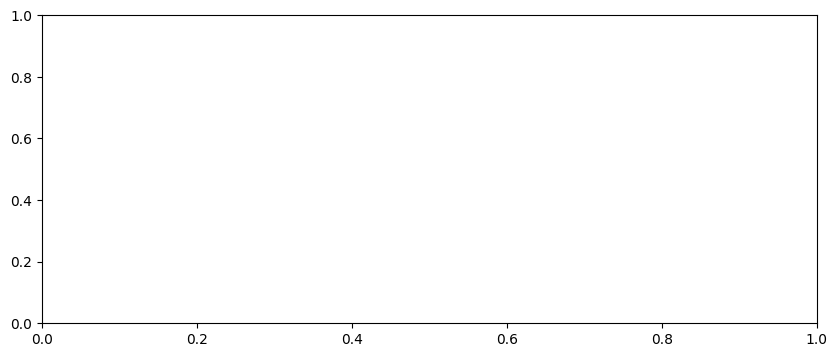

In [30]:


# Mostra il primo spettrogramma del batch
plt.figure(figsize=(10, 4))
plt.imshow(spectrogram[0].squeeze(0).numpy(), aspect='auto', origin='lower')
plt.title(f"Score: {score[0].item():.2f}")
plt.colorbar(label='Amplitude')
plt.xlabel("Time")
plt.ylabel("Mel bins")
plt.tight_layout()
plt.show()


# MODEL

In [26]:
import torch.nn as nn
import torch.nn.functional as F

class AudioQualityCNN(nn.Module):
    def __init__(self):
        super(AudioQualityCNN, self).__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),  # [16, 64, 1200]

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),  # [32, 32, 600]

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2))   # [64, 16, 300]
        )

        self.fc_block = nn.Sequential(
            nn.Flatten(),                      # [64 * 16 * 300] = 307200
            nn.Linear(64 * 16 * 300, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 1)                  # Output: qualità
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.fc_block(x)
        return x.squeeze(1)  # Output shape: [batch_size]


# TRAIN

In [27]:
import torch
from torch.utils.data import DataLoader
from torch import nn
from tqdm import tqdm
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AudioQualityCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()  # oppure nn.L1Loss() per MAE diretta
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)


def train(model, train_loader, val_loader, epochs=20):
    best_val_loss = float('inf')
    patience = 3
    epochs_without_improvement = 0

    os.makedirs("model", exist_ok=True)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_mae = 0.0

        loop = tqdm(train_loader, total=len(train_loader))

        for batch in loop:
            inputs = batch['spectrogram'].to(device)
            targets = batch['score'].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            # MAE per batch
            batch_mae = torch.mean(torch.abs(outputs - targets)).item()
            running_mae += batch_mae * inputs.size(0)

            loop.set_description(f"\033[34mEpoch [{epoch+1}/{epochs}]\033[0m")
            loop.set_postfix(loss=loss.item(), mae=batch_mae)

        avg_train_loss = running_loss / len(train_loader.dataset)
        avg_train_mae = running_mae / len(train_loader.dataset)

        scheduler.step(avg_train_loss)

        tqdm.write(f"\033[34mEpoch [{epoch+1}/{epochs}]\033[0m, "
                   f"Train Loss: {avg_train_loss:.4f}, Train MAE: {avg_train_mae:.2f}")

        #### VALIDATION ####
        model.eval()
        val_loss = 0.0
        val_mae = 0.0

        with torch.no_grad():
            for batch in val_loader:
                inputs = batch['spectrogram'].to(device)
                targets = batch['score'].to(device)
                outputs = model(inputs)

                loss = loss_fn(outputs, targets)
                val_loss += loss.item() * inputs.size(0)

                batch_mae = torch.mean(torch.abs(outputs - targets)).item()
                val_mae += batch_mae * inputs.size(0)

        avg_val_loss = val_loss / len(val_loader.dataset)
        avg_val_mae = val_mae / len(val_loader.dataset)

        tqdm.write(f"\033[32mValidation Loss: {avg_val_loss:.4f}, Validation MAE: {avg_val_mae:.2f}\033[0m")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "model/best_model.pth")
            epochs_without_improvement = 0
            tqdm.write(f"\033[32mModel saved!\033[0m")
        else:
            epochs_without_improvement += 1
            tqdm.write(f"\033[31mNo improvement ({epochs_without_improvement}/{patience})\033[0m")

        if epochs_without_improvement >= patience:
            tqdm.write(f"\033[31mEarly stopping triggered\033[0m")
            break


In [29]:
train(model, train_loader, val_loader, epochs=30)


Epoch [1/30]: 100%|██████████| 6/6 [00:18<00:00,  3.11s/it, loss=587, mae=19.2]


Epoch [1/30], Train Loss: 673.4465, Train MAE: 21.66
Validation Loss: 864.6388, Validation MAE: 26.59
Model saved!


Epoch [2/30]: 100%|██████████| 6/6 [00:18<00:00,  3.12s/it, loss=1.02e+3, mae=27.9]


Epoch [2/30], Train Loss: 713.6727, Train MAE: 22.19
Validation Loss: 907.2527, Validation MAE: 26.66
No improvement (1/3)


Epoch [3/30]: 100%|██████████| 6/6 [00:18<00:00,  3.11s/it, loss=602, mae=20.6]


Epoch [3/30], Train Loss: 700.6142, Train MAE: 22.24
Validation Loss: 847.1121, Validation MAE: 25.48
Model saved!


Epoch [4/30]: 100%|██████████| 6/6 [00:18<00:00,  3.09s/it, loss=636, mae=22]  


Epoch [4/30], Train Loss: 666.6382, Train MAE: 21.42
Validation Loss: 841.0141, Validation MAE: 25.81
Model saved!


Epoch [5/30]: 100%|██████████| 6/6 [00:18<00:00,  3.11s/it, loss=577, mae=21.7]


Epoch [5/30], Train Loss: 655.6476, Train MAE: 21.16
Validation Loss: 862.5699, Validation MAE: 25.92
No improvement (1/3)


Epoch [6/30]: 100%|██████████| 6/6 [00:18<00:00,  3.12s/it, loss=1.28e+3, mae=28.9]


Epoch [6/30], Train Loss: 677.8350, Train MAE: 21.50
Validation Loss: 922.6269, Validation MAE: 27.18
No improvement (2/3)


Epoch [7/30]: 100%|██████████| 6/6 [00:18<00:00,  3.12s/it, loss=645, mae=22.9]


Epoch [7/30], Train Loss: 647.8408, Train MAE: 21.41
Validation Loss: 919.3894, Validation MAE: 26.68
No improvement (3/3)
Early stopping triggered
